In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install kaggle


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d xilezhu/lc25000

Dataset URL: https://www.kaggle.com/datasets/xilezhu/lc25000
License(s): unknown
 99% 1.74G/1.76G [00:11<00:00, 102MB/s] 
100% 1.76G/1.76G [00:12<00:00, 157MB/s]


In [ ]:
!unzip lc25000.zip -d lc25000

Streaming output truncated to the last 5000 lines.
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca10.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1008.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1010.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1020.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1024.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1032.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1035.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1045.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1046.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1051.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1052.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1053.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1056.jpeg  
  

In [ ]:
#normal dataset converted to gray scale

In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# Set the base path to your dataset
base_path = '/content/lc25000/LC25000/lung_split'

# Define subfolders for each class
class_folders = {
    'lung_n': ['train/lung_n', 'val/lung_n'],
    'lung_aca': ['train/lung_aca', 'val/lung_aca']
}

# Labels
label_map = {
    'lung_n': 0,
    'lung_aca': 1
}

# Initialize data storage
data = []
labels = []

# Loop through each class
for class_name, folders in class_folders.items():
    count = 0
    max_images = 5000

    print(f"\n📁 Processing {class_name}...")

    for folder in folders:
        folder_path = os.path.join(base_path, folder)

        if not os.path.exists(folder_path):
            print(f"❌ Folder not found: {folder_path}")
            continue

        for filename in tqdm(os.listdir(folder_path)):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)

                # Read image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Skip unreadable images
                if img is None:
                    print(f"⚠️ Couldn't read image: {img_path}")
                    continue

                # Resize to fixed size
                img = cv2.resize(img, (64, 64))

                # Flatten image to 1D vector
                img_flat = img.flatten()

                # Sanity check
                if len(img_flat) != 64 * 64:
                    print(f"⚠️ Invalid image shape at: {img_path}")
                    continue

                # Append to dataset
                data.append(img_flat)
                labels.append(label_map[class_name])
                count += 1

                if count >= max_images:
                    break
        if count >= max_images:
            break

print(f"\n✅ Total samples collected: {len(data)}")

# Final check before creating DataFrame
if data:
    df = pd.DataFrame(data)
    df['label'] = labels
    df.to_csv('merged_lung_dataset_grayscale.csv', index=False)
    print("✅ CSV saved as 'merged_lung_dataset_grayscale.csv'")
else:
    print("❌ No data was collected. Please check image paths and formats.")



📁 Processing lung_n...


100%|█████████▉| 999/1000 [00:01<00:00, 567.92it/s]



📁 Processing lung_aca...


100%|█████████▉| 999/1000 [00:01<00:00, 566.25it/s]



✅ Total samples collected: 10000
✅ CSV saved as 'merged_lung_dataset_grayscale.csv'


In [ ]:
from google.colab import files
files.download('merged_lung_dataset_grayscale.csv')

In [ ]:
#fuzzy filter

In [ ]:
pip install scikit-fuzzy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 23.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv('/content/merged_lung_dataset_grayscale (2).csv')

# Split features and labels (assuming last column is label)
pixels = df.iloc[:, :-1].values  # all columns except last
labels = df.iloc[:, -1].values   # last column as label

# Normalize pixel data to [0, 1] range
scaler = MinMaxScaler()
pixels_normalized = scaler.fit_transform(pixels)

# Adaptive Fuzzy Filter Function
def adaptive_fuzzy_filter(image_flat):
    # Assume input is 1D flattened image, reshape to square if needed
    img_size = int(np.sqrt(len(image_flat)))
    image = image_flat.reshape((img_size, img_size))

    # Create fuzzy membership functions for low, medium, high intensities
    x = np.linspace(0, 1, 100)
    low = fuzz.trimf(x, [0, 0, 0.5])
    med = fuzz.trimf(x, [0.25, 0.5, 0.75])
    high = fuzz.trimf(x, [0.5, 1, 1])

    filtered_image = np.zeros_like(image)

    # Apply fuzzy logic to each pixel
    for i in range(img_size):
        for j in range(img_size):
            val = image[i, j]
            low_val = fuzz.interp_membership(x, low, val)
            med_val = fuzz.interp_membership(x, med, val)
            high_val = fuzz.interp_membership(x, high, val)

            # Adaptive smoothing rule:
            # If medium dominates, preserve value; if high or low, smooth using neighborhood
            if med_val > max(low_val, high_val):
                filtered_image[i, j] = val
            else:
                # Simple 3x3 neighborhood averaging for smoothing
                neighbors = image[max(0, i-1):i+2, max(0, j-1):j+2]
                filtered_image[i, j] = np.mean(neighbors)

    return filtered_image.flatten()

# Apply adaptive fuzzy filtering to all images
filtered_pixels = np.array([adaptive_fuzzy_filter(img) for img in pixels_normalized])

# Combine with labels again
filtered_df = pd.DataFrame(filtered_pixels)
filtered_df['label'] = labels

# Save to new CSV file
filtered_df.to_csv('lung_dataset_fuzzy_filtered.csv', index=False)

print("Filtered dataset saved as 'lung_dataset_fuzzy_filtered.csv'")


Filtered dataset saved as 'lung_dataset_fuzzy_filtered.csv'


In [ ]:
from google.colab import files
files.download('lung_dataset_fuzzy_filtered.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#HOG applied

In [ ]:
import pandas as pd
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Load fuzzy-filtered dataset
df = pd.read_csv('/content/lung_dataset_fuzzy_filtered (1).csv')

# Split features and labels
pixels = df.iloc[:, :-1].values  # all columns except the last
labels = df.iloc[:, -1].values   # last column is label

# Determine image size (assuming square images)
img_size = int(np.sqrt(pixels.shape[1]))

# HOG parameters (you can tune these for better results)
hog_features = []
for img_flat in pixels:
    img = img_flat.reshape((img_size, img_size))

    features = hog(img,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   visualize=False,
                   feature_vector=True)

    hog_features.append(features)

# Convert to DataFrame
hog_df = pd.DataFrame(hog_features)
hog_df['label'] = labels

# Save HOG features to CSV
hog_df.to_csv('lung_dataset_HOG_features.csv', index=False)

print("HOG features saved to 'lung_dataset_HOG_features.csv'")

HOG features saved to 'lung_dataset_HOG_features.csv'


In [ ]:
from google.colab import files
files.download('lung_dataset_HOG_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np

# Load dataset
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Separate features and label
X = df.drop('label', axis=1).values
y = df['label'].values

# Indices for each class
normal_indices = np.where(y == 0)[0]  # Assuming 0 = Normal
cancer_indices = np.where(y == 1)[0]  # Assuming 1 = Cancer

# Shuffle to avoid ordering bias
np.random.seed(42)
np.random.shuffle(normal_indices)
np.random.shuffle(cancer_indices)

# Split each class into train/val/test (80/10/10)
def split_indices(indices):
    n = len(indices)
    train_end = int(0.8 * n)
    val_end = int(0.9 * n)
    return indices[:train_end], indices[train_end:val_end], indices[val_end:]

normal_train, normal_val, normal_test = split_indices(normal_indices)
cancer_train, cancer_val, cancer_test = split_indices(cancer_indices)

# Combine indices
train_indices = np.concatenate([normal_train, cancer_train])
val_indices = np.concatenate([normal_val, cancer_val])
test_indices = np.concatenate([normal_test, cancer_test])

# Shuffle the final splits
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

# Split the data
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Define classifiers
classifiers = {
    "SVM": SVC(),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print results
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


ValueError: The number of classes has to be greater than one; got 1 class


===== CatBoost =====
Accuracy: 0.8685
Confusion Matrix:
[[873 127]
 [136 864]]


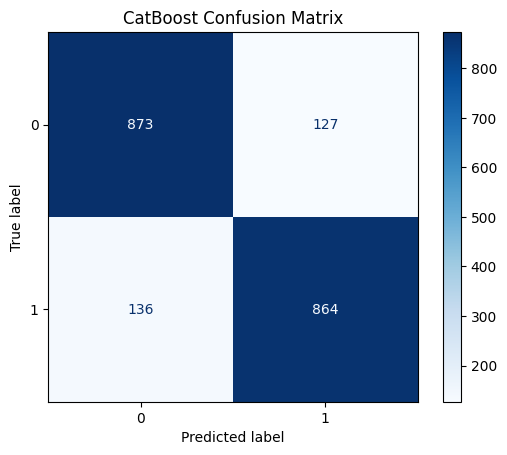


===== ExtraTrees =====
Accuracy: 0.8510
Confusion Matrix:
[[878 122]
 [176 824]]


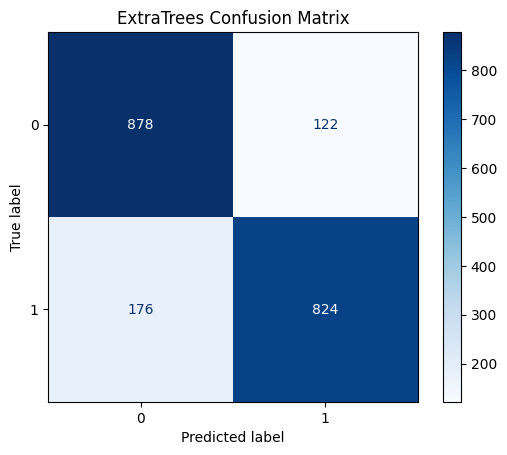


===== SVM =====
Accuracy: 0.8810
Confusion Matrix:
[[891 109]
 [129 871]]


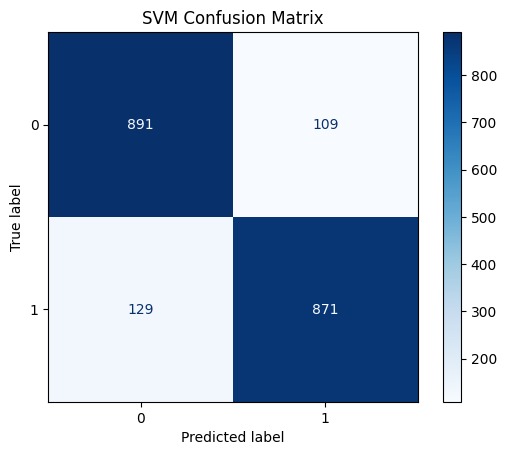


===== MLP =====
Accuracy: 0.8850
Confusion Matrix:
[[886 114]
 [116 884]]


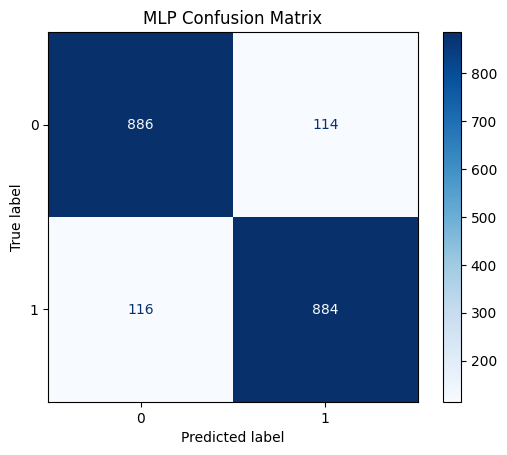


===== KNN =====
Accuracy: 0.6090
Confusion Matrix:
[[ 218  782]
 [   0 1000]]


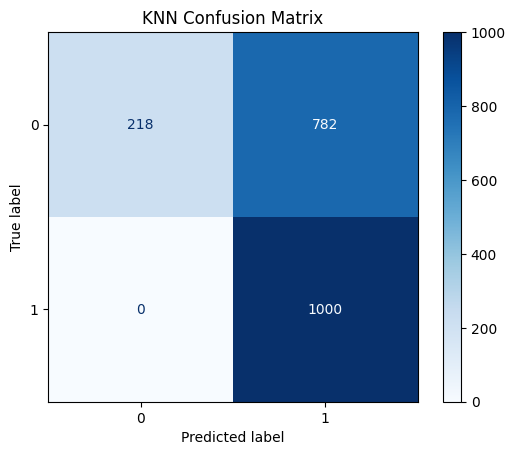


===== GradientBoosting =====
Accuracy: 0.8320
Confusion Matrix:
[[820 180]
 [156 844]]


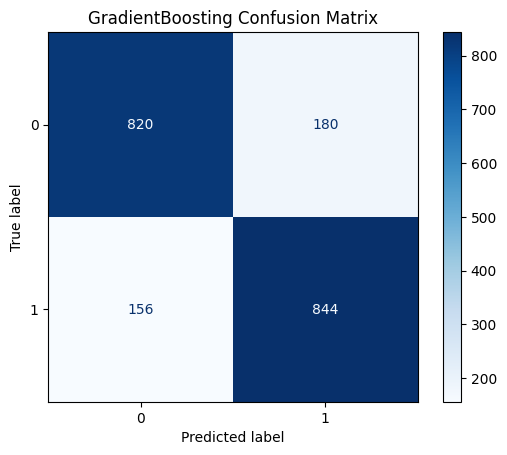

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/lung_dataset_HOG_features.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [ ]:
#LPB applied

In [ ]:
import pandas as pd
import numpy as np
from skimage.feature import local_binary_pattern

# Parameters for LBP
radius = 1
n_points = 8 * radius
method = 'uniform'  # You can also try 'default' or 'ror'

# Load fuzzy-filtered dataset
df = pd.read_csv('/content/lung_dataset_fuzzy_filtered (1).csv')

# Split features and labels
pixels = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

# Determine image size
img_size = int(np.sqrt(pixels.shape[1]))

# Extract LBP features
lbp_features = []
for img_flat in pixels:
    img = img_flat.reshape((img_size, img_size))

    # Apply LBP
    lbp = local_binary_pattern(img, n_points, radius, method)

    # Build histogram of LBP patterns (normalized)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    lbp_features.append(hist)

# Convert to DataFrame
lbp_df = pd.DataFrame(lbp_features)
lbp_df['label'] = labels

# Save LBP features to CSV
lbp_df.to_csv('lung_dataset_LBP_features.csv', index=False)

print("LBP features saved to 'lung_dataset_LBP_features.csv'")

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP features saved to 'lung_dataset_LBP_features.csv'


In [ ]:
from google.colab import files
files.download('lung_dataset_LBP_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np

# Load dataset
df = pd.read_csv('/content/lung_dataset_LBP_features.csv')

# Separate features and label
X = df.drop('label', axis=1).values
y = df['label'].values

# Indices for each class
normal_indices = np.where(y == 0)[0]  # Assuming 0 = Normal
cancer_indices = np.where(y == 1)[0]  # Assuming 1 = Cancer

# Shuffle to avoid ordering bias
np.random.seed(42)
np.random.shuffle(normal_indices)
np.random.shuffle(cancer_indices)

# Split each class into train/val/test (80/10/10)
def split_indices(indices):
    n = len(indices)
    train_end = int(0.8 * n)
    val_end = int(0.9 * n)
    return indices[:train_end], indices[train_end:val_end], indices[val_end:]

normal_train, normal_val, normal_test = split_indices(normal_indices)
cancer_train, cancer_val, cancer_test = split_indices(cancer_indices)

# Combine indices
train_indices = np.concatenate([normal_train, cancer_train])
val_indices = np.concatenate([normal_val, cancer_val])
test_indices = np.concatenate([normal_test, cancer_test])

# Shuffle the final splits
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

# Split the data
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Define classifiers
classifiers = {
    "SVM": SVC(),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print results
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


SVM: 0.9020
GradientBoost: 0.9030
KNN: 0.9000
ExtraTrees: 0.9150
MLP: 0.8930
CatBoost: 0.9180



===== CatBoost =====
Accuracy: 0.9230
Confusion Matrix:
[[945  55]
 [ 99 901]]


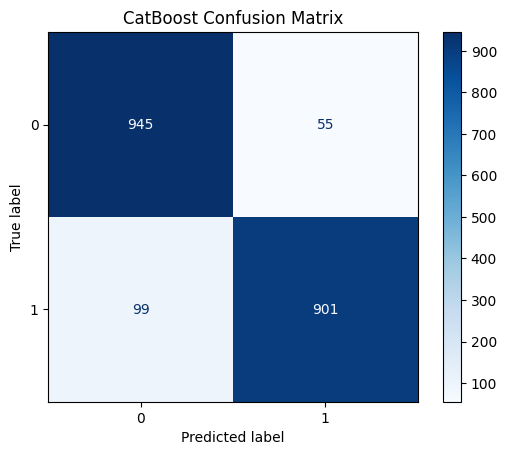


===== ExtraTrees =====
Accuracy: 0.9215
Confusion Matrix:
[[944  56]
 [101 899]]


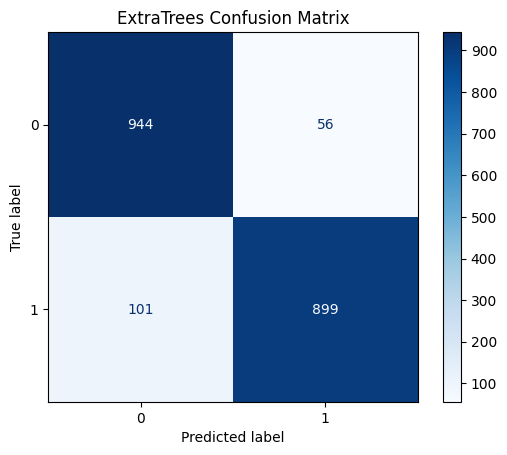


===== SVM =====
Accuracy: 0.9125
Confusion Matrix:
[[943  57]
 [118 882]]


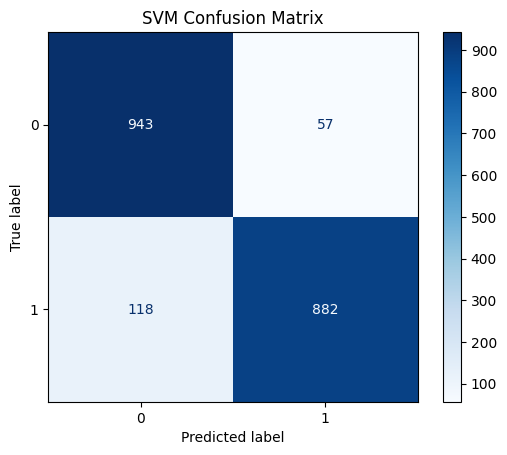


===== MLP =====
Accuracy: 0.9120
Confusion Matrix:
[[925  75]
 [101 899]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


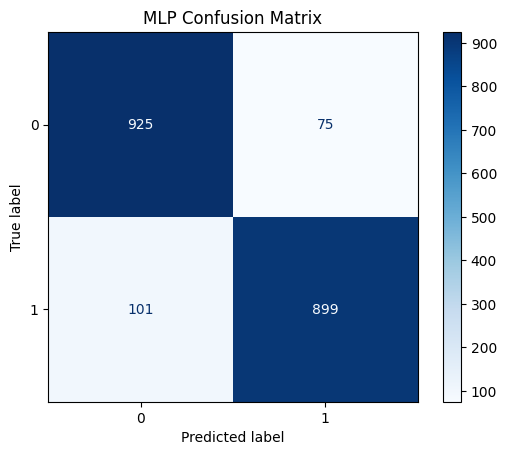


===== KNN =====
Accuracy: 0.8980
Confusion Matrix:
[[920  80]
 [124 876]]


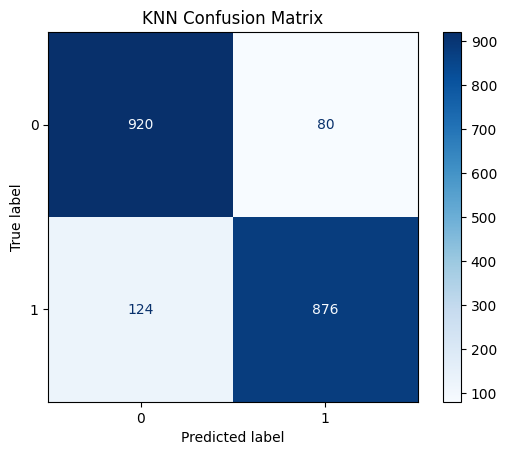


===== GradientBoosting =====
Accuracy: 0.9090
Confusion Matrix:
[[929  71]
 [111 889]]


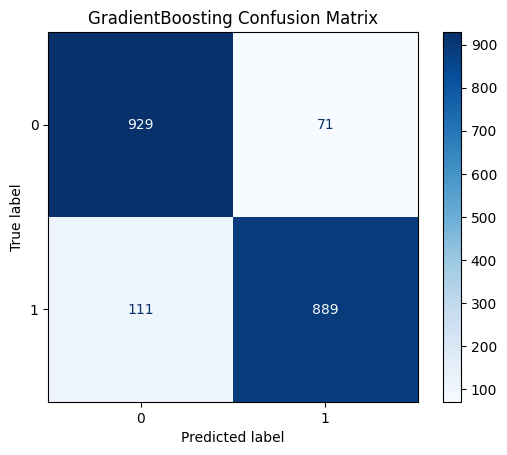

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/lung_dataset_LBP_features.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [ ]:
#HOG given to RSA

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Set global random seed for reproducibility
np.random.seed(42)

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)  # Seeded above
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOG_RSA_selected.csv', index=False)

print(f"Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'")
print(f"Number of selected features: {selected_features_mask.sum()}")

Iteration 1/15 — Best Fitness: 0.7823 — Time: 71.39s
Iteration 2/15 — Best Fitness: 0.7823 — Time: 70.31s
Iteration 3/15 — Best Fitness: 0.7830 — Time: 70.26s
Iteration 4/15 — Best Fitness: 0.7833 — Time: 71.14s
Iteration 5/15 — Best Fitness: 0.7844 — Time: 70.81s
Iteration 6/15 — Best Fitness: 0.7861 — Time: 70.82s
Iteration 7/15 — Best Fitness: 0.7861 — Time: 70.03s
Iteration 8/15 — Best Fitness: 0.7861 — Time: 70.40s
Iteration 9/15 — Best Fitness: 0.7866 — Time: 73.39s
Iteration 10/15 — Best Fitness: 0.7866 — Time: 72.62s
Iteration 11/15 — Best Fitness: 0.7866 — Time: 71.15s
Iteration 12/15 — Best Fitness: 0.7866 — Time: 72.42s
Iteration 13/15 — Best Fitness: 0.7866 — Time: 71.42s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_HOGNEW_RSA_selected.csv'
Number of selected features: 900


In [ ]:
from google.colab import files
files.download('lung_dataset_HOG_RSA_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
csv_path = '/content/lung_dataset_HOG_RSA_selected (1).csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.8590
ExtraTrees Accuracy: 0.8535
SVM Accuracy: 0.8730
MLP Accuracy: 0.8770
KNN Accuracy: 0.6050
GradientBoosting Accuracy: 0.8310



===== CatBoost =====
Accuracy: 0.8590
Confusion Matrix:
[[866 134]
 [148 852]]


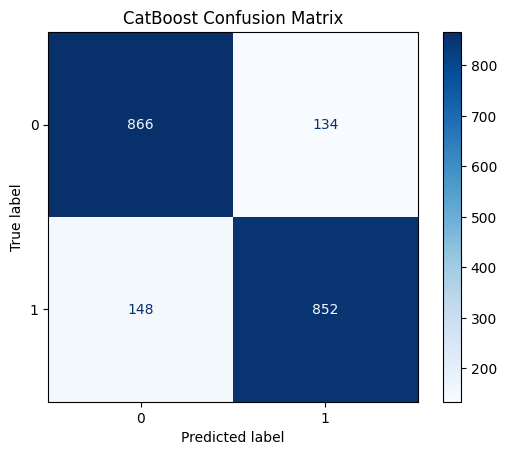


===== ExtraTrees =====
Accuracy: 0.8535
Confusion Matrix:
[[873 127]
 [166 834]]


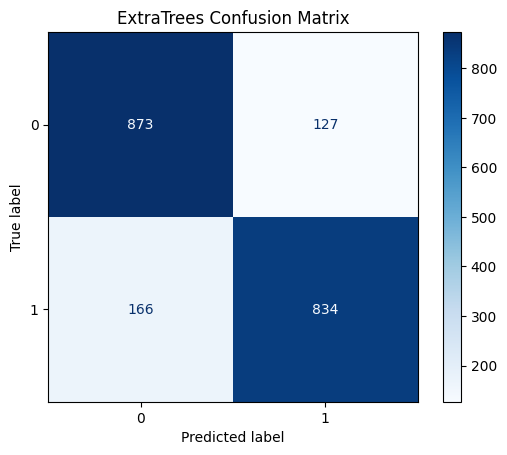


===== SVM =====
Accuracy: 0.8730
Confusion Matrix:
[[886 114]
 [140 860]]


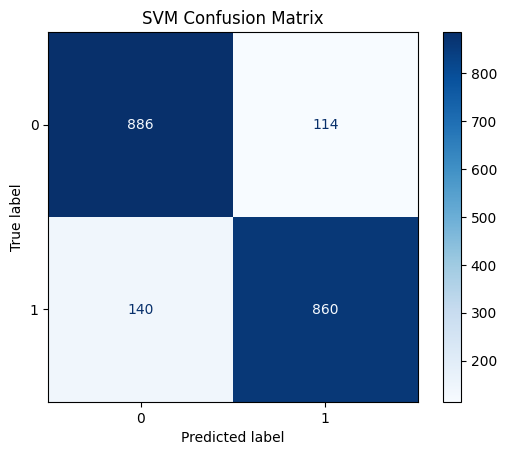


===== MLP =====
Accuracy: 0.8770
Confusion Matrix:
[[883 117]
 [129 871]]


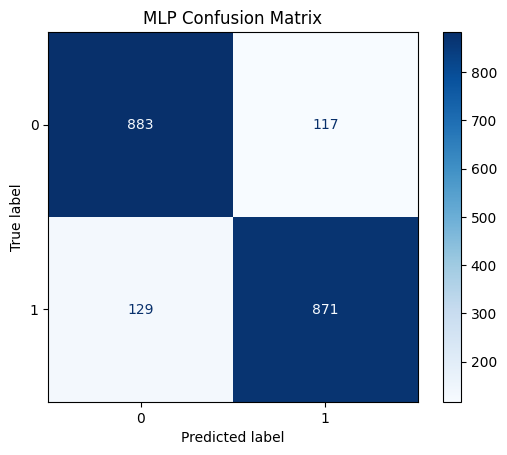


===== KNN =====
Accuracy: 0.6050
Confusion Matrix:
[[ 210  790]
 [   0 1000]]


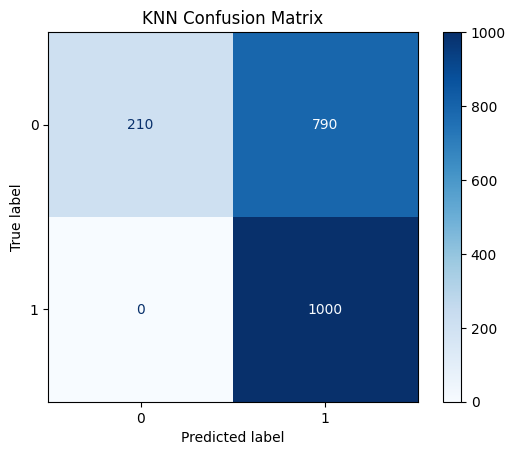


===== GradientBoosting =====
Accuracy: 0.8310
Confusion Matrix:
[[822 178]
 [160 840]]


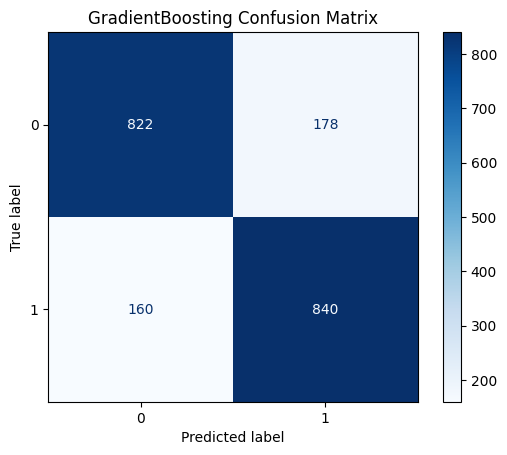

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/lung_dataset_HOG_RSA_selected (1).csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [ ]:
#LPB given to RSA

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Set global random seed for reproducibility
np.random.seed(42)

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)  # Seeded above
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_LBP_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_LPB_RSA_selected.csv', index=False)

print(f"Selected features saved to 'lung_dataset_LPB_RSA_selected.csv'")
print(f"Number of selected features: {selected_features_mask.sum()}")

Iteration 1/15 — Best Fitness: 0.8981 — Time: 2.30s
Iteration 2/15 — Best Fitness: 0.8981 — Time: 2.34s
Iteration 3/15 — Best Fitness: 0.8981 — Time: 2.38s
Iteration 4/15 — Best Fitness: 0.8991 — Time: 3.23s
Iteration 5/15 — Best Fitness: 0.9033 — Time: 3.42s
Iteration 6/15 — Best Fitness: 0.9033 — Time: 2.46s
Iteration 7/15 — Best Fitness: 0.9033 — Time: 2.56s
Iteration 8/15 — Best Fitness: 0.9033 — Time: 2.45s
Iteration 9/15 — Best Fitness: 0.9033 — Time: 3.00s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_LPB_RSA_selected.csv'
Number of selected features: 7


In [ ]:
from google.colab import files
files.download('lung_dataset_LBP_RSA_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
csv_path = '/content/lung_dataset_LBP_RSA_selected (1).csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.9180
ExtraTrees Accuracy: 0.9205
SVM Accuracy: 0.9160
MLP Accuracy: 0.9090
KNN Accuracy: 0.8975
GradientBoosting Accuracy: 0.9105



===== CatBoost =====
Accuracy: 0.9180
Confusion Matrix:
[[937  63]
 [101 899]]


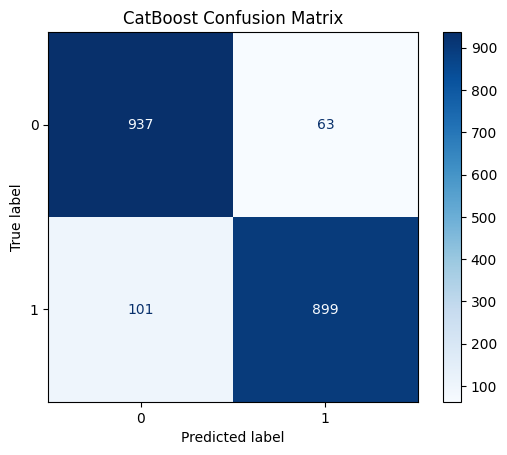


===== ExtraTrees =====
Accuracy: 0.9205
Confusion Matrix:
[[940  60]
 [ 99 901]]


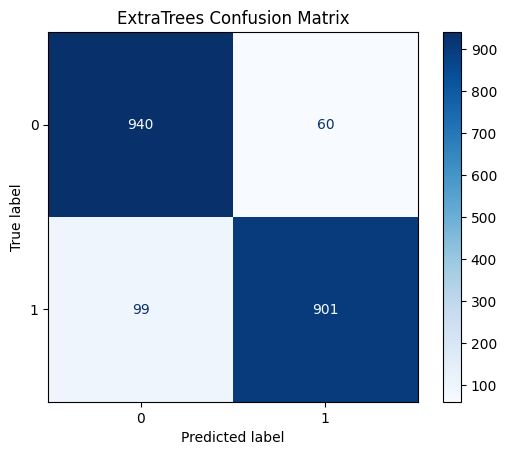


===== SVM =====
Accuracy: 0.9160
Confusion Matrix:
[[946  54]
 [114 886]]


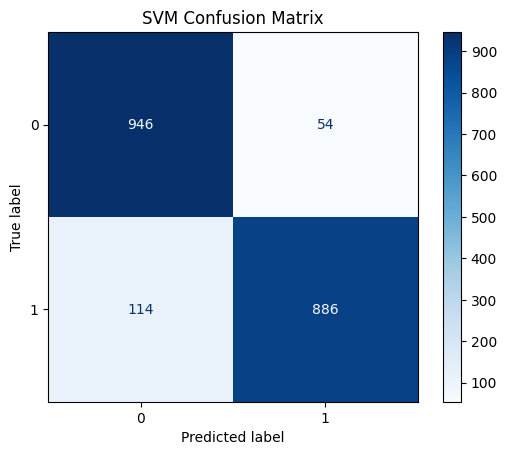


===== MLP =====
Accuracy: 0.9090
Confusion Matrix:
[[916  84]
 [ 98 902]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


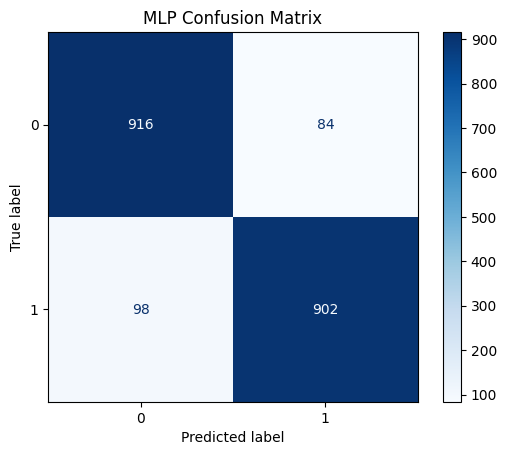


===== KNN =====
Accuracy: 0.8975
Confusion Matrix:
[[922  78]
 [127 873]]


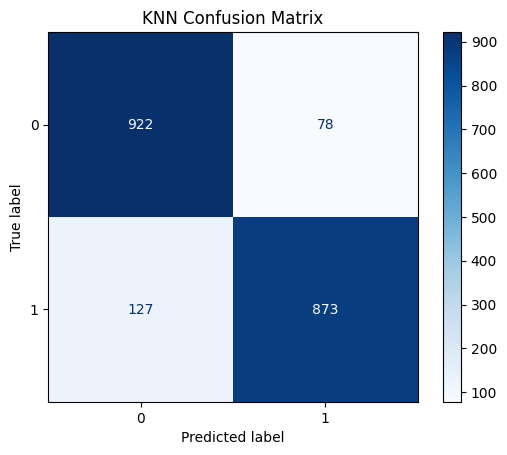


===== GradientBoosting =====
Accuracy: 0.9105
Confusion Matrix:
[[928  72]
 [107 893]]


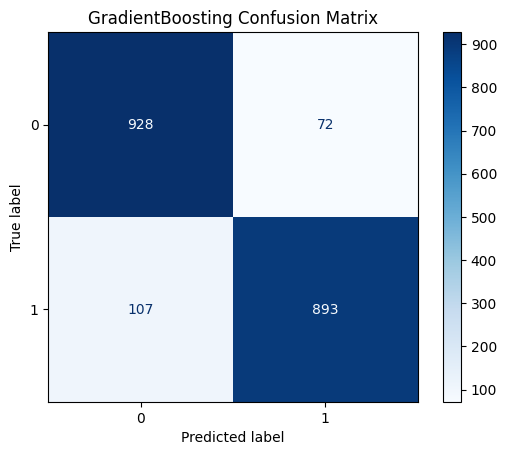

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/lung_dataset_LBP_RSA_selected (1).csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [ ]:
#fusion of HOG and LPB

In [ ]:
import pandas as pd

# Load the datasets
hog_df = pd.read_csv("lung_dataset_HOG_features.csv")
lbp_df = pd.read_csv("lung_dataset_LBP_features.csv")

# Check if both datasets have the same number of rows
if hog_df.shape[0] == lbp_df.shape[0]:
    # Concatenate the datasets column-wise
    fused_df = pd.concat([hog_df, lbp_df], axis=1)

    # Save the fused dataset to a new CSV file
    fused_df.to_csv("lung_dataset_HOG_LBP_fused.csv", index=False)

    print("Fusion successful. Saved as 'lung_dataset_HOG_LBP_fused.csv'")
else:
    print("Error: The datasets have different number of rows.")


Fusion successful. Saved as 'lung_dataset_HOG_LBP_fused.csv'


In [ ]:
from google.colab import files
files.download('lung_dataset_HOG_LBP_fused.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
csv_path = '/content/fusion of HOG and LPB.xlsx'
df = pd.read_excel(csv_path)


# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.9400
ExtraTrees Accuracy: 0.8800
SVM Accuracy: 0.9235
MLP Accuracy: 0.9275
KNN Accuracy: 0.6280
GradientBoosting Accuracy: 0.9285



===== CatBoost =====
Accuracy: 0.9400
Confusion Matrix:
[[958  42]
 [ 78 922]]


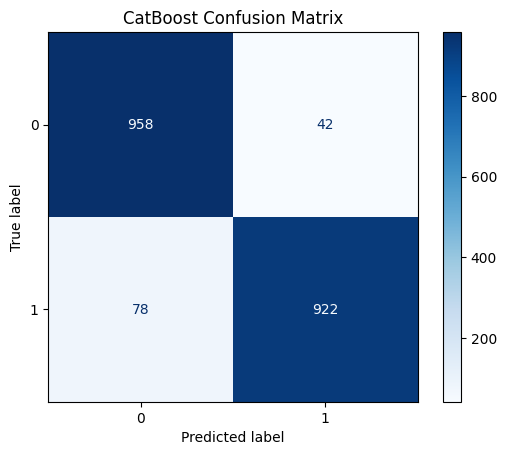


===== ExtraTrees =====
Accuracy: 0.8800
Confusion Matrix:
[[949  51]
 [189 811]]


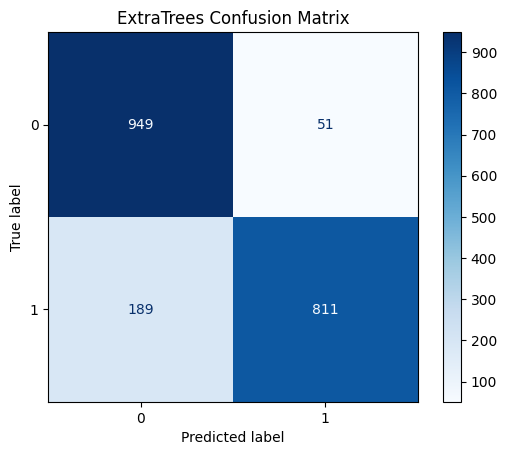


===== SVM =====
Accuracy: 0.9235
Confusion Matrix:
[[950  50]
 [103 897]]


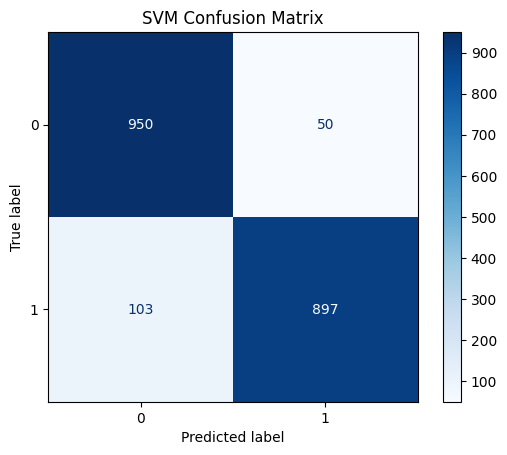


===== MLP =====
Accuracy: 0.9275
Confusion Matrix:
[[938  62]
 [ 83 917]]


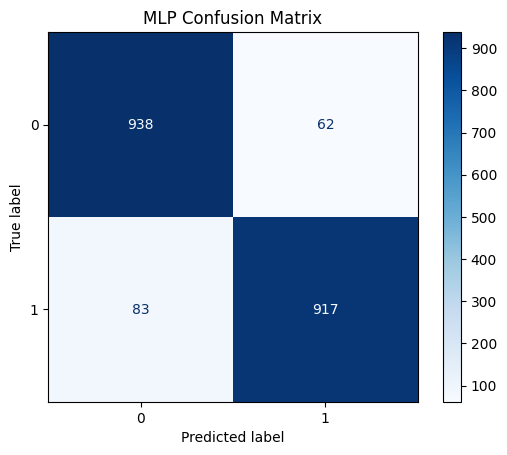


===== KNN =====
Accuracy: 0.6280
Confusion Matrix:
[[257 743]
 [  1 999]]


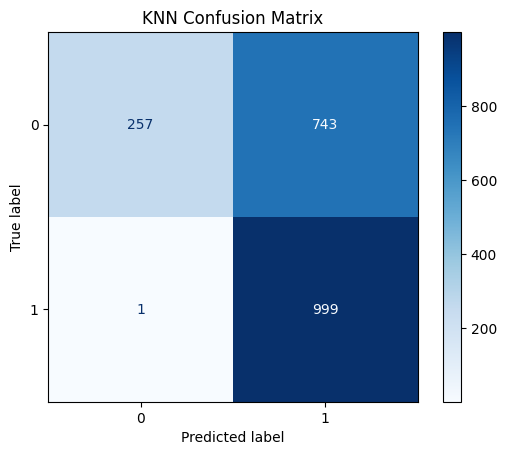


===== GradientBoosting =====
Accuracy: 0.9285
Confusion Matrix:
[[953  47]
 [ 96 904]]


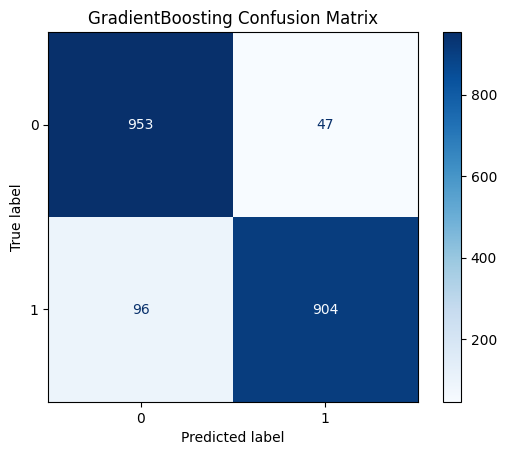

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/fusion of HOG and LPB.xlsx'
df = pd.read_excel(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

In [ ]:
#fusion of HOG and LPB applied to RSA

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Set global random seed for reproducibility
np.random.seed(42)

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)  # Seeded above
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/fusion of HOG and LPB CSV.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOGLPB_RSA_selected.csv', index=False)

print(f"Selected features saved to 'lung_dataset_HOGLPB_RSA_selected.csv'")
print(f"Number of selected features: {selected_features_mask.sum()}")

Iteration 1/15 — Best Fitness: 0.8615 — Time: 77.95s
Iteration 2/15 — Best Fitness: 0.8664 — Time: 76.97s
Iteration 3/15 — Best Fitness: 0.8664 — Time: 75.48s
Iteration 4/15 — Best Fitness: 0.8702 — Time: 77.17s
Iteration 5/15 — Best Fitness: 0.8702 — Time: 75.47s
Iteration 6/15 — Best Fitness: 0.8702 — Time: 77.00s
Iteration 7/15 — Best Fitness: 0.8740 — Time: 75.04s
Iteration 8/15 — Best Fitness: 0.8740 — Time: 78.05s
Iteration 9/15 — Best Fitness: 0.8740 — Time: 76.41s
Iteration 10/15 — Best Fitness: 0.8740 — Time: 76.15s
Iteration 11/15 — Best Fitness: 0.8740 — Time: 77.51s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_HOGLPB_RSA_selected.csv'
Number of selected features: 854


In [ ]:
from google.colab import files
files.download('lung_dataset_HOGLPB_RSA_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
csv_path = '/content/lung_dataset_HOGLPB_RSA_selected.csv'
df = pd.read_csv(csv_path)


# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.9460
ExtraTrees Accuracy: 0.8980
SVM Accuracy: 0.9345
MLP Accuracy: 0.9320
KNN Accuracy: 0.6265
GradientBoosting Accuracy: 0.9275



===== CatBoost =====
Accuracy: 0.9460
Confusion Matrix:
[[968  32]
 [ 76 924]]


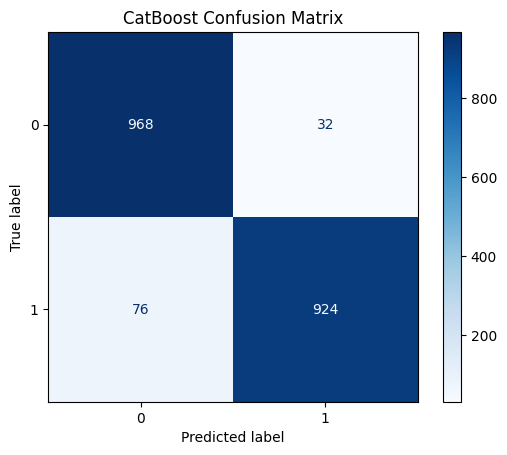


===== ExtraTrees =====
Accuracy: 0.8980
Confusion Matrix:
[[957  43]
 [161 839]]


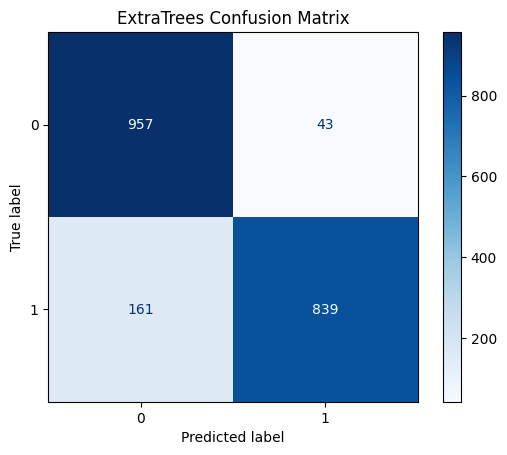


===== SVM =====
Accuracy: 0.9345
Confusion Matrix:
[[958  42]
 [ 89 911]]


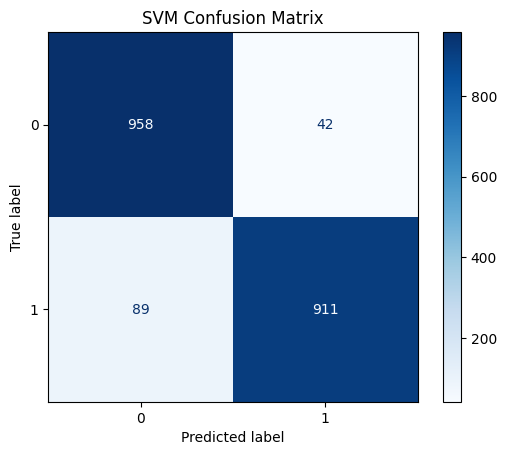


===== MLP =====
Accuracy: 0.9320
Confusion Matrix:
[[936  64]
 [ 72 928]]


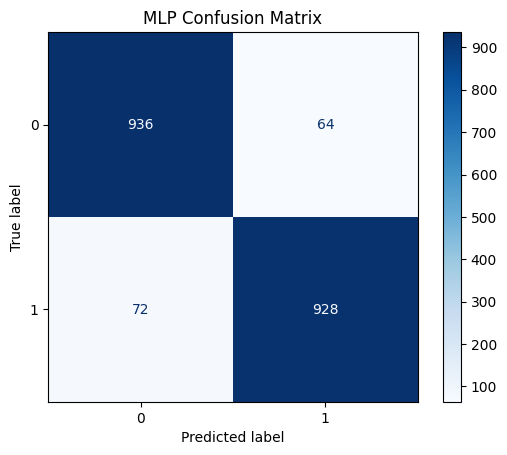


===== KNN =====
Accuracy: 0.6265
Confusion Matrix:
[[255 745]
 [  2 998]]


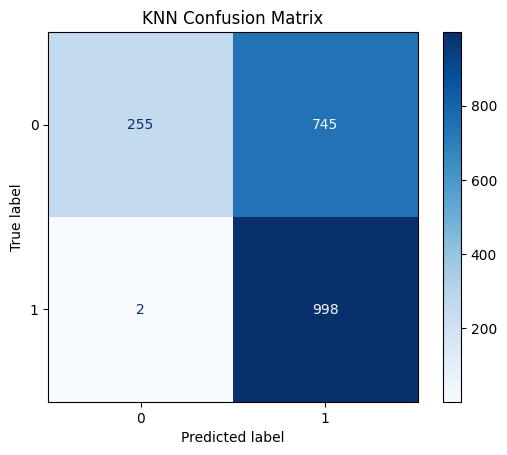


===== GradientBoosting =====
Accuracy: 0.9275
Confusion Matrix:
[[951  49]
 [ 96 904]]


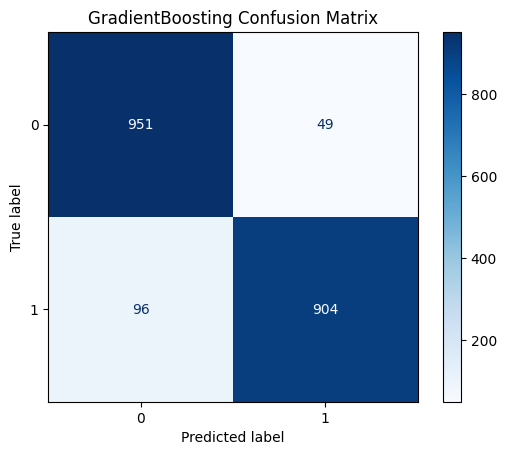

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/lung_dataset_HOGLPB_RSA_selected.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()